In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
ticker = 'MSFT'
df_orig = yf.download(ticker)
df_orig.index = pd.to_datetime(df_orig.index)
df_orig = df_orig.droplevel('Ticker', axis=1)


[*********************100%***********************]  1 of 1 completed


In [3]:
df_orig.head(3)

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1986-03-13 00:00:00+00:00,0.059946,0.097222,0.101563,0.088542,0.088542,1031788800
1986-03-14 00:00:00+00:00,0.062087,0.100694,0.102431,0.097222,0.097222,308160000
1986-03-17 00:00:00+00:00,0.063158,0.102431,0.103299,0.100694,0.100694,133171200


In [4]:
df = df_orig.copy()

In [5]:
columns_to_lag = ['Open','Close','High','Low', 'Volume', 'Adj Close']
days_to_lag = 5

## add columns looking back up to five days
## add columns giving Adj Close change compared to 1, 2, 3, 4 and 5 days back

for lag in range(1, days_to_lag + 1):
    df[f"change_back_{lag}"] = df["Adj Close"].pct_change(lag)
    for col in columns_to_lag[::-1]:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)



In [6]:
df.dropna(inplace=True)

In [7]:
df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'change_back_1',
       'Adj Close_lag1', 'Volume_lag1', 'Low_lag1', 'High_lag1', 'Close_lag1',
       'Open_lag1', 'change_back_2', 'Adj Close_lag2', 'Volume_lag2',
       'Low_lag2', 'High_lag2', 'Close_lag2', 'Open_lag2', 'change_back_3',
       'Adj Close_lag3', 'Volume_lag3', 'Low_lag3', 'High_lag3', 'Close_lag3',
       'Open_lag3', 'change_back_4', 'Adj Close_lag4', 'Volume_lag4',
       'Low_lag4', 'High_lag4', 'Close_lag4', 'Open_lag4', 'change_back_5',
       'Adj Close_lag5', 'Volume_lag5', 'Low_lag5', 'High_lag5', 'Close_lag5',
       'Open_lag5'],
      dtype='object', name='Price')

In [8]:
df["change_day_1"] = df["Adj Close"].pct_change(-1)*-100
df["change_day_2"] = df["Adj Close"].pct_change(-2)*-100
df.dropna(inplace=True)

In [9]:
start_train = "2010-01-01"
end_train = "2022-12-31"
start_test = "2023-01-01"

df_train = df.loc[start_train:end_train].copy().drop(columns=["change_day_1","change_day_2"])
df_test = df.loc[start_test:].copy().drop(columns=["change_day_1","change_day_2"])

y_train = df.loc[start_train:end_train,["change_day_1","change_day_2"]].copy()
y_test  = df.loc[start_test:,["change_day_1", "change_day_2"]].copy()


In [10]:
from sklearn.tree import DecisionTreeRegressor

In [11]:
model_dtr = DecisionTreeRegressor(max_depth=8)
model_dtr.fit(X=df_train, y=y_train)

DecisionTreeRegressor(max_depth=8)

In [12]:
model_dtr.predict(df_train[0:5])

array([[-0.01662761,  0.04884923],
       [ 0.14800417,  0.26985978],
       [-0.01662761,  0.04884923],
       [-0.01662761,  0.04884923],
       [-0.01662761,  0.04884923]])

In [13]:
from backtesting import Backtest, Strategy

In [14]:
from backtesting import Backtest, Strategy

In [15]:
class RegressionModel(Strategy):
    def init(self):
        self.model = model_dtr
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1],:]
        predict = self.model.predict(explanatory_today)[0]
        forecast_tomorrow = predict[0]
        forecast_day_after = predict[1]
        
        # conditions to sell or buy
        if forecast_tomorrow >0 and forecast_day_after>0 and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif (forecast_tomorrow < 0 or forecast_day_after<0 )  and self.already_bought == True:
            self.sell()
            self.already_bought = False 
        else:
            pass

In [19]:
bt = Backtest(data=df_test, strategy=RegressionModel,
              cash=10000, commission=.002, exclusive_orders=True)

In [20]:
result = bt.run()

In [21]:
result["Return [%]"]

2.7026495297241673

## Same data, train neural network

In [560]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(100,30,), activation='relu', solver='adam', max_iter=900)
model.fit(df_train, y_train)



MLPRegressor(hidden_layer_sizes=(100, 30), max_iter=900)

In [563]:
class RegressionModel(Strategy):
    def init(self):
        self.model = model
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1],:]
        predict = self.model.predict(explanatory_today)[0]
        forecast_tomorrow = predict[0]
        forecast_day_after = predict[1]
        
        # conditions to sell or buy
        if forecast_tomorrow >0  and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif (forecast_tomorrow < 0  )  and self.already_bought == True:
            self.sell()
            self.already_bought = False 
        else:
            pass

In [564]:
bt = Backtest(data=df_train, strategy=RegressionModel,
              cash=10000, commission=.002, exclusive_orders=True)
result = bt.run()
print(result["Return [%]"])

-97.36145570448389


## Very bad result, not correct usage?

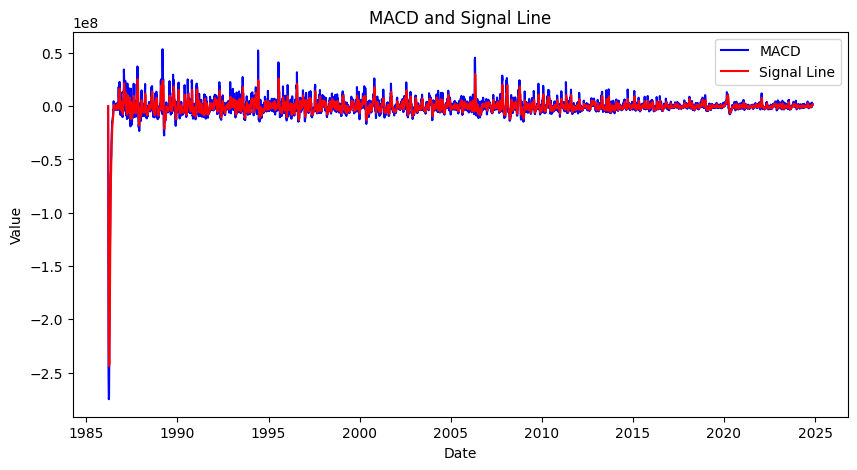

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data
# data = {
#     'Date': ['2024-11-01', '2024-11-02', '2024-11-03', '2024-11-04', '2024-11-05', 
#              '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-09', '2024-11-10'],
#     'Close': [100, 102, 101, 103, 104, 106, 105, 107, 108, 110]
# }
# df = pd.DataFrame(data)
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Calculate the short-term (12-day) EMA
df['EMA_12'] = df['Volume'].ewm(span=12, adjust=False).mean()

# Calculate the long-term (26-day) EMA
df['EMA_26'] = df['Volume'].ewm(span=26, adjust=False).mean()

# Calculate the MACD line
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Calculate the Signal line (9-day EMA of MACD)
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Plot the MACD and Signal Line
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['MACD'], label='MACD', color='blue')
plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()
